In [1]:
import os

import json
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import pandas as pd

from io import StringIO
from io import BytesIO
import random


# Carga de la información

In [2]:
# Ruta de la carpeta con las fotos
carpeta = "C:/Users/lriverosq/Downloads/FOTOS"
file_path = "C:/Users/lriverosq/Downloads/BD_Instagram.csv"

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)
bd_imagen = pd.read_csv(file_path, sep = ";")

bd_imagen.columns = bd_imagen.columns.str.strip()
bd_imagen.columns = bd_imagen.columns.str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u').str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U')  # Reemplazar tildes

In [3]:
imagenes = [archivo for archivo in archivos if archivo.lower().endswith(('.jpg'))]

# Crear listas para almacenar los nombres y las imágenes
imagenes_cargadas = []

# Cargar imágenes y nombres en las listas
for imagen in imagenes:
    ruta_imagen = os.path.join(carpeta, imagen)

    imagenes_cargadas.append(ruta_imagen)

# Se crea dataframe con las imagenes y los nombres de cada imágen
df_imagen = pd.DataFrame({
    'NOMBRE': imagenes,
    'IMAGEN': imagenes_cargadas
})

df_imagen['NOMBRE'] = df_imagen['NOMBRE'].str.replace('.jpg', '', regex= False)

In [4]:
df_imagen = pd.merge(df_imagen, bd_imagen,on = "NOMBRE" )

# Convertir las imagenes a JPEG para que se puedan procesar
def convertir_a_jpeg(ruta):
    try:
        with Image.open(ruta) as img:
            nueva_ruta = ruta.replace('.jpg')
            img.convert('RGB').save(nueva_ruta, 'JPEG')
            return nueva_ruta
    except Exception as e:
        print(f"Error al convertir: {ruta}")
        return None

df_imagen['IMAGEN'] = df_imagen['IMAGEN'].apply(lambda x: convertir_a_jpeg(x) if x.endswith('.tif') else x)

In [5]:
 # Carga y preprocesa la imagen desde una ruta
def cargar_y_preprocesar_imagen(ruta):
    try: 
          imagen = tf.io.read_file(ruta)
          imagen = tf.image.decode_image(imagen, channels=1)  # Decodificar a escala de grises
          imagen = tf.image.resize(imagen, [100, 100])  # Ajustar al tamaño en pixeles 
          imagen = tf.keras.utils.img_to_array(imagen) # Cargar array
          imagen = imagen / 255.0  # Normalizar a [0, 1]
          return imagen
    except Exception as e:
        print(f"Error al cargar la imagen {ruta}: {e}")
        return None
    

df_imagen['IMAGEN_COD'] = df_imagen['IMAGEN'].apply(cargar_y_preprocesar_imagen)
df_imagen['IMAGEN_COD'].head()

0    [[[0.078039214], [0.0969804], [0.12078431], [0...
1    [[[0.91764706], [0.91764706], [0.91764706], [0...
2    [[[0.093333334], [0.20782156], [0.21026471], [...
3    [[[0.7647059], [0.7647059], [0.7647059], [0.76...
4    [[[0.33270586], [0.326], [0.32196078], [0.6276...
Name: IMAGEN_COD, dtype: object

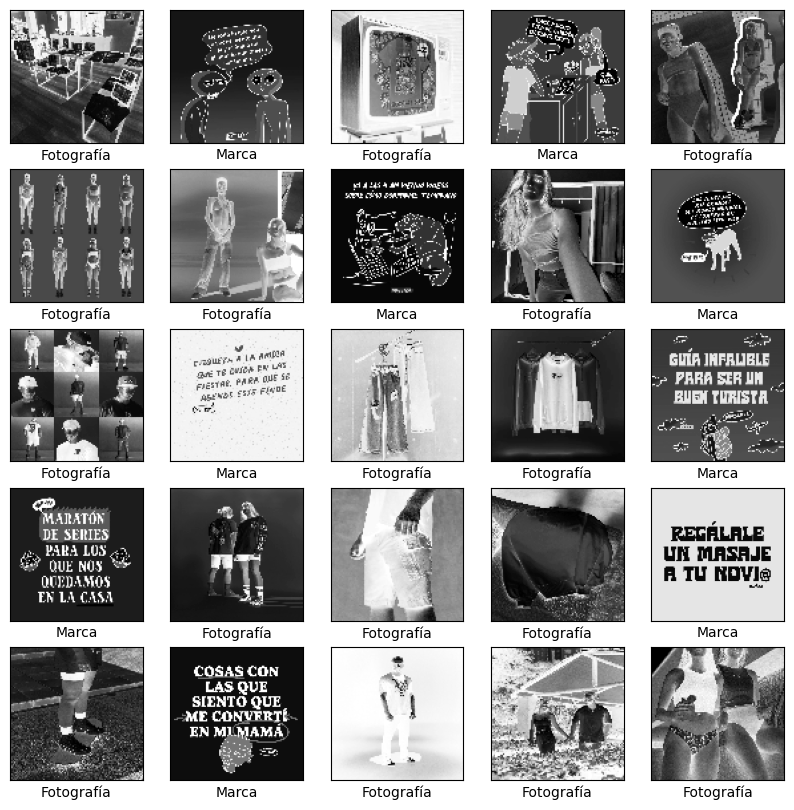

In [6]:
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(df_imagen.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(row['IMAGEN_COD'], cmap=plt.cm.binary)
    plt.xlabel(row['AREA'])

plt.show()

# Procesamiento de la Data

In [7]:
etiq = df_imagen['AREA'].unique()
print("etiquetas:", etiq)

df_imagen['AREA'] = df_imagen['AREA'].str.replace('mARCA','Marca') # Se hace una limpieza de las etiquetas 

df_imagen = df_imagen[(df_imagen['AREA'] == 'Fotografía') | (df_imagen['AREA'] == 'Marca')]

etiq_recod = df_imagen['AREA'].unique()
print("etiquetas:", etiq_recod)

etiquetas: ['Fotografía' 'Marca' 'Comercial' 'Híbrido' 'mARCA' 'Colaboración']
etiquetas: ['Fotografía' 'Marca']


In [8]:
# Selección de las variables de interes X y Y
X = df_imagen['IMAGEN']
Y = df_imagen['AREA']                           

# Se paración del set de en entrenamiento y validación en un 70% entrenamiento, 30% validación
X_train, X_vald, y_train, y_vald = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Tamaño dataset entrenamiento:", len(y_train))
print("Tamaño dataset validación:", len(y_vald))

# Se crea un codificador
label_encoder = LabelEncoder()

# Se convierten las etiquetas categóricas a números enteros
y_train = label_encoder.fit_transform(y_train)
y_vald = label_encoder.fit_transform(y_vald)
y_train

# Convertir a One-Hot Encoding
y_train = to_categorical(y_train)
y_vald = to_categorical(y_vald)

# Convertimos los datos de la variable independiente en array
X_train_arrays = np.array([cargar_y_preprocesar_imagen(ruta) for ruta in X_train])
X_vald_arrays = np.array([cargar_y_preprocesar_imagen(ruta) for ruta in X_vald])

Tamaño dataset entrenamiento: 2886
Tamaño dataset validación: 1237


# Aplicación de metodos de optimización para red neuronal convolucional 

1. Primer optimizador: Simulated Annealing

In [ ]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

def evaluate(params):
    filtros_capa1, filtros_capa2, filtros_capa3, dense_units, dropout_rate = params
    
    # Estructura base del modelo de red convolucional
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filtros_capa1, (3, 3), activation='relu', input_shape=(100, 100, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(filtros_capa2, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(filtros_capa3, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    # Entrenamiento
    model.fit(X_train_arrays, y_train, 
              validation_data=(X_vald_arrays, y_vald), 
              epochs=10, batch_size=32, verbose=0, callbacks=[early_stopping])
    
    # Evaluación
    _, val_accuracy = model.evaluate(X_vald_arrays, y_vald, verbose=0)
    return val_accuracy 





In [ ]:
# Algoritmo de Simulated Annealing

def simulated_annealing(initial_params, schedule, max_iter=30):
    current_params = initial_params
    current_value = evaluate(current_params)
    best_params, best_value = current_params, current_value

    print(f"Initial params: {current_params}, Accuracy: {current_value:.4f}")

    for t in range(1, max_iter + 1):
        T = schedule(t)
        if T == 0:
            break

        # Rango de movimiento para cada parámetro
        filtros_range = np.array([16, 32, 64, 128])
        dense_range = np.array([128, 256, 512])
        dropout_range = np.array([0.3, 0.5, 0.7])

        # Generación de nuevo conjunto de parámetros
        if np.random.rand() >= 0.5:
            new_params = (
                np.random.choice(filtros_range),
                np.random.choice(filtros_range),
                np.random.choice(filtros_range),
                np.random.choice(dense_range),
                np.random.choice(dropout_range)
            )
        else:

            new_params = (
                np.random.choice(filtros_range),
                np.random.choice(filtros_range),
                np.random.choice(filtros_range),
                np.random.choice(dense_range),
                np.random.choice(dropout_range)
            )


        new_value = evaluate(new_params)
        delta_E = new_value - current_value

        if delta_E > 0 or np.random.rand() < np.exp(delta_E / T):
            current_params, current_value = new_params, new_value
            print(f"Iteración {t}: NUEVO aceptado {new_params}, Accuracy: {new_value:.4f}")
            if new_value > best_value:
                best_params, best_value = new_params, new_value
                print(" --> Nuevo mejor modelo encontrado!")
        else:
            print(f"Iteración {t}: Rechazado {new_params}, Accuracy: {new_value:.4f}")

    return best_params, best_value



In [ ]:
def schedule(t):
    T0 = 1.0
    return max(0, T0 - t / 30) 


# Hiperparámetros iniciales
initial_params = (32, 32, 64, 256, 0.5, 0.001) 



best_params, best_accuracy = simulated_annealing(initial_params, schedule)

print("Mejores hiperparámetros encontrados:", best_params)
print("Precisión obtenida con SA:", best_accuracy)

c:\Users\lriverosq\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Initial params: (32, 32, 64, 256, 0.5, 0.001), Accuracy: 0.9305
Iteración 1: NUEVO aceptado (np.int64(16), np.int64(16), np.int64(128), np.int64(256), np.float64(0.5), np.float64(0.0001)), Accuracy: 0.9264
Iteración 2: NUEVO aceptado (np.int64(32), np.int64(16), np.int64(64), np.int64(256), np.float64(0.7), np.float64(0.0001)), Accuracy: 0.9232
Iteración 3: NUEVO aceptado (np.int64(128), np.int64(16), np.int64(64), np.int64(128), np.float64(0.5), np.float64(0.01)), Accuracy: 0.7065
Iteración 4: NUEVO aceptado (np.int64(32), np.int64(32), np.int64(128), np.int64(512), np.float64(0.3), np.float64(0.01)), Accuracy: 0.7065
Iteración 5: NUEVO aceptado (np.int64(128), np.int64(32), np.int64(64), np.int64(256), np.float64(0.5), np.float64(0.0001)), Accuracy: 0.9289
Iteración 6: NUEVO aceptado (np.int64(16), np.int64(16), np.int64(32), np.int64(512), np.float64(0.5), np.float64(0.0001)), Accuracy: 0.9184
Iteración 7: NUEVO aceptado (np.int64(32), np.int64(32), np.int64(32), np.int64(128), np.f

2. Segundo optimizador: Genetic Algorithm (Algoritmo Genético)

In [ ]:
# Función de fitness para evaluar el desempeño de cada individuo
def fitness(individual):
    filtros_capa1, filtros_capa2, filtros_capa3, dropout_rate, dense_units = individual

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(int(filtros_capa1), (3, 3), activation='relu', input_shape=(100, 100, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(int(filtros_capa2), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(int(filtros_capa3), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Dropout(float(dropout_rate)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(dense_units), activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid')  # 2 clases de salida
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_arrays, y_train, epochs=5, batch_size=32, verbose=0)  
    
    _, val_accuracy = model.evaluate(X_vald_arrays, y_vald, verbose=0)
    return val_accuracy  

# Función para selección de padres
def select_parents(population, fitness_scores):
    probs = fitness_scores / fitness_scores.sum()
    selected = np.random.choice(len(population), size=2, replace=False, p=probs)
    return population[selected[0]], population[selected[1]]

# Función de recombinación basada en el redondeo del promedio
def reproduce(parent1, parent2):
    child = np.round((parent1 + parent2) / 2).astype(float)
    child[:3] = np.round(child[:3]).astype(int)  # Los filtros deben ser enteros
    return child

# Función de mutación
def mutate(child, mutation_rate=0.2):
    if np.random.rand() < mutation_rate:
        index = np.random.randint(len(child))
        if index == 0:
            child[index] = np.random.choice([16, 32, 64, 128])  # filtros_capa1
        elif index == 1:
            child[index] = np.random.choice([16, 32, 64, 128])  # filtros_capa2
        elif index == 2:
            child[index] = np.random.choice([16, 32, 64, 128])  # filtros_capa3
        elif index == 3:
            child[index] = np.random.uniform(0.1, 0.5)  # dropout_rate
        else:
            child[index] = np.random.randint([128, 256, 512])  # dense_units
    return child



In [ ]:
# Generar población inicial
population_size = 10
population = np.column_stack((
    np.random.choice([16, 32, 64, 128], size=population_size),  # filtros_capa1
    np.random.choice([16, 32, 64, 128], size=population_size),  # filtros_capa2
    np.random.choice([16, 32, 64, 128], size=population_size),  # filtros_capa3
    np.random.uniform(0.1, 0.5, size=population_size),  # dropout_rate
    np.random.randint([128, 256, 512], size=population_size)  # dense_units
))
print("Población Inicial: ", population)

generations = 10  # Número máximo de generaciones
for gen in range(generations):
    fitness_scores = np.array([fitness(ind) for ind in population]) 
    new_population = []
    for _ in range(population_size):
        parent1, parent2 = select_parents(population, fitness_scores)
        child = reproduce(parent1, parent2)
        child = mutate(child)
        new_population.append(child)
    population = np.array(new_population)  

# Seleccionar el mejor individuo final
best_individual = population[np.argmax([fitness(ind) for ind in population])]
print(f"Mejor configuración encontrada: filtros_capa1={int(best_individual[0])}, filtros_capa2={int(best_individual[1])}, filtros_capa3={int(best_individual[2])}, dropout_rate={best_individual[3]:.2f}, dense_units={int(best_individual[4])}")

# Entrenar el modelo final con los mejores hiperparámetros
best_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(int(best_individual[0]), (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(int(best_individual[1]), (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(int(best_individual[2]), (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(float(best_individual[3])),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(int(best_individual[4]), activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit(X_train_arrays, y_train, epochs=20, batch_size=32) 
loss, accuracy = best_model.evaluate(X_vald_arrays, y_vald)

print(f"Precisión final en test: {accuracy:.4f}")


Población Inicial:  [[1.28000000e+02 1.28000000e+02 6.40000000e+01 4.03739518e-01
  3.70000000e+02]
 [1.60000000e+01 1.28000000e+02 1.60000000e+01 3.60448224e-01
  2.38000000e+02]
 [3.20000000e+01 1.28000000e+02 1.28000000e+02 1.15873401e-01
  2.56000000e+02]
 [6.40000000e+01 6.40000000e+01 6.40000000e+01 4.25550546e-01
  1.95000000e+02]
 [1.60000000e+01 1.28000000e+02 1.60000000e+01 4.05029254e-01
  2.17000000e+02]
 [1.60000000e+01 6.40000000e+01 1.60000000e+01 2.82112987e-01
  2.13000000e+02]
 [1.28000000e+02 1.28000000e+02 1.60000000e+01 3.12730581e-01
  2.06000000e+02]
 [6.40000000e+01 1.28000000e+02 1.28000000e+02 1.43734427e-01
  2.00000000e+02]
 [1.28000000e+02 3.20000000e+01 1.28000000e+02 1.58413098e-01
  3.44000000e+02]
 [6.40000000e+01 1.28000000e+02 1.60000000e+01 3.03515496e-01
  2.19000000e+02]]
Mejor configuración encontrada: filtros_capa1=58, filtros_capa2=118, filtros_capa3=68, dropout_rate=0.00, dense_units=274
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - ac

3. Optimizador 3: Hill Climbing (Ascenso de Colinas)

In [ ]:
def train_and_evaluate(filtros_capa1, filtros_capa2, filtros_capa3, dropout_rate, dense_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(int(filtros_capa1), (3, 3), activation='relu', input_shape=(100, 100, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(int(filtros_capa2), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(int(filtros_capa3), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Dropout(float(dropout_rate)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(dense_units), activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid')  
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Entrenamiento
    model.fit(X_train_arrays, y_train, epochs=5, batch_size=32, verbose=0)
    
    loss, accuracy = model.evaluate(X_vald_arrays, y_vald, verbose=0)
    return accuracy


In [ ]:
def hill_climbing(max_filtros=128, max_dropout=0.5, max_dense_units=500, restart_threshold=5, max_iterations=50):
    current_filtros_capa1 = random.choice([16, 32, 64, 128])
    current_filtros_capa2 = random.choice([16, 32, 64, 128])
    current_filtros_capa3 = random.choice([16, 32, 64, 128])
    current_dropout_rate = round(random.uniform(0.1, max_dropout), 2)
    current_dense_units = random.randint(50, max_dense_units)
    
    # Evaluar la configuración inicial
    current_score = train_and_evaluate(current_filtros_capa1, current_filtros_capa2, current_filtros_capa3, current_dropout_rate, current_dense_units)
    print(f"Configuración inicial: filtros_capa1={current_filtros_capa1}, filtros_capa2={current_filtros_capa2}, filtros_capa3={current_filtros_capa3}, dropout_rate={current_dropout_rate}, dense_units={current_dense_units}, accuracy={current_score:.4f}")

    best_filtros_capa1 = current_filtros_capa1
    best_filtros_capa2 = current_filtros_capa2
    best_filtros_capa3 = current_filtros_capa3
    best_dropout_rate = current_dropout_rate
    best_dense_units = current_dense_units
    best_score = current_score

    no_improvement_count = 0
    iterations = 0

    while iterations < max_iterations:
        neighbors = []
        
        for _ in range(10):
            new_filtros_capa1 = random.choice([16, 32, 64, 128])
            new_filtros_capa2 = random.choice([16, 32, 64, 128])
            new_filtros_capa3 = random.choice([16, 32, 64, 128])
            new_dropout_rate = round(max(0.1, min(max_dropout, current_dropout_rate + random.uniform(-0.05, 0.05))), 2)
            new_dense_units = max(50, min(max_dense_units, current_dense_units + random.randint(-50, 50)))
            
            neighbors.append((new_filtros_capa1, new_filtros_capa2, new_filtros_capa3, new_dropout_rate, new_dense_units))
        
        best_neighbor_score = -1
        best_neighbor = None
        for neighbor in neighbors:
            score = train_and_evaluate(*neighbor)
            if score > best_neighbor_score:
                best_neighbor_score = score
                best_neighbor = neighbor

        if best_neighbor_score > current_score:
            current_filtros_capa1, current_filtros_capa2, current_filtros_capa3, current_dropout_rate, current_dense_units = best_neighbor
            current_score = best_neighbor_score
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if current_score > best_score:
            best_filtros_capa1 = current_filtros_capa1
            best_filtros_capa2 = current_filtros_capa2
            best_filtros_capa3 = current_filtros_capa3
            best_dropout_rate = current_dropout_rate
            best_dense_units = current_dense_units
            best_score = current_score

        if no_improvement_count >= restart_threshold:
            print(f"Reinicio aleatorio tras {no_improvement_count} iteraciones sin mejora.")
            current_filtros_capa1 = random.choice([16, 32, 64, 128])
            current_filtros_capa2 = random.choice([16, 32, 64, 128])
            current_filtros_capa3 = random.choice([16, 32, 64, 128])
            current_dropout_rate = round(random.uniform(0.1, max_dropout), 2)
            current_dense_units = random.randint(50, max_dense_units)
            current_score = train_and_evaluate(current_filtros_capa1, current_filtros_capa2, current_filtros_capa3, current_dropout_rate, current_dense_units)
            no_improvement_count = 0
        iterations += 1
    
    return best_filtros_capa1, best_filtros_capa2, best_filtros_capa3, best_dropout_rate, best_dense_units, best_score


In [17]:
best_filtros_capa1, best_filtros_capa2, best_filtros_capa3, best_dropout_rate, best_dense_units, best_score = hill_climbing()

print(f"Mejor configuración encontrada: filtros_capa1={best_filtros_capa1}, filtros_capa2={best_filtros_capa2}, filtros_capa3={best_filtros_capa3}, dropout_rate={best_dropout_rate}, dense_units={best_dense_units}, accuracy={best_score:.4f}")


Configuración inicial: filtros_capa1=64, filtros_capa2=64, filtros_capa3=32, dropout_rate=0.46, dense_units=267, accuracy=0.9192
Reinicio aleatorio tras 5 iteraciones sin mejora.
Reinicio aleatorio tras 5 iteraciones sin mejora.
Reinicio aleatorio tras 5 iteraciones sin mejora.


: 

In [ ]:
# Entrenar el mejor modelo encontrado
best_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(best_filtros_capa1, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(best_filtros_capa2, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(best_filtros_capa3, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(best_dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(best_dense_units, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit(X_train_arrays, y_train, epochs=20, batch_size=32)

loss, accuracy = best_model.evaluate(X_vald_arrays, y_vald)
print(f"Precisión final en test: {accuracy:.4f}")